# Insurance Regression Project

## Main Objective

The main objective of the project is to use regression supervised models to predict a target value. The subject of the dataset that will be used is insurance and in this case the target that we want to predict is the amount to be charged to the beneficiary based on the values of other parameters and characteristics of this. This analysis would be beneficial to find patterns within the data, and see if certain values on certain features affect the insurance charges of each individual. To make this possible we try multiple models and ended up using a Ridge Regression model with Polynomial Features and Standard Scaling; as it gave us the best results. 

The data we are working with is a Medical Cost Personal Dataset, it has more than 1300 entries and 7 features including the target of the prediction model, charges, that is going to be developed within this project.

- Age: age of the beneficiary
- Sex: the gender of the contractor
- BMI: the body mass index
- Children: number of children covered by the health insurance
- Smoker: if the beneficiary is a smoker or not
- Region: the beneficiary´s residential area: northeast, northwest, southeast, southwest
- Charges: individual medical cost billed by insurance


## Data Cleaning and Feature Engineering

We are going to import the libraries and then the dataset.

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('insurance.csv')

First we check the information and a snippet of the data, we can see that the columns "sex", "smoker" and "region" are of type object, so we are going to use Label Encoder of Scikit-Learn to change them to numerical values.

In [5]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
le = LabelEncoder()
# Male or Female
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)
# Smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)
#Region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

Now when checking for the distribution of the charges data we can see that it is not normalized, if we check it using the Shapiro Test it give us a value of around 1.90e-36, to try and correct that there are two changes that we are going to apply to our target, we are going to apply the method Winsorize from Sci-Py and then apply the Yeo-Johnson Transformation, this two change are going to be applied in this case to the whole target just for the plot, later we are going to apply them but just to the y_train. This give us Shapiro Test Score of around 2.08e-16, this is a more normal distribution, but not a perfect one, there are methods like Quantile Transformer from Scikit-Learn that makes the Shapiro Test Score 0.001, but in this case, the Yeo-Johnson Transformation gives us a better R² and RMSE Score when writting our model. We can see the distribution of the charges data before and after the Yeo-Johnson Transformation.

In [8]:
X = data.drop('charges', axis=1)
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

y_train = winsorize(y_train, limits=[0.05, 0.05])
y_winsorize = winsorize(y, limits=[0.05, 0.05])

pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.reshape(-1, 1)).flatten()
y_transformed = pt.fit_transform(y_winsorize.reshape(-1, 1)).flatten()

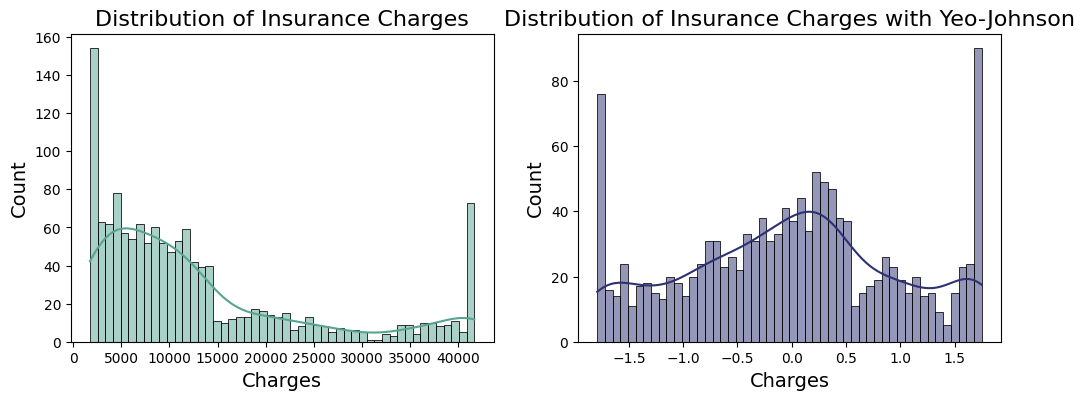

In [9]:
plt.figure(figsize=(12,4))

ax=plt.subplot(121)
sns.histplot(y_winsorize,bins=50,color='#57a490',ax=ax, kde=True)
ax.set_title('Distribution of Insurance Charges', fontsize=16)
ax.set_xlabel('Charges', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

ax=plt.subplot(122)
sns.histplot(y_transformed,bins=50,color='#2c3172',ax=ax, kde=True)
ax.set_title('Distribution of Insurance Charges with Yeo-Johnson', fontsize=16)
ax.set_xlabel('Charges', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

plt.show()

Now we are going to use the Shapiro test to check if the data is normally distributed, if the pvalue of the result is greater that 0.05. then we can say that the data is normally distributed.

In [10]:
sh_charges = shapiro(y_winsorize)
sh_charges

ShapiroResult(statistic=0.8176066247580637, pvalue=1.9029453111606016e-36)

The data without transformations has a p-value of <b>≈ 1.90e-36</b>, this means the data is not normally distributed. Now we are going to use the Shapiro test to check if the data is normally distributed with a log transformation

In [11]:

sh_log_charges = shapiro(y_transformed)
sh_log_charges

ShapiroResult(statistic=0.9687501142561774, pvalue=2.0839718601215186e-16)

Doing the yeo-johnson transformations changes the data to a more normal distribution, there are better methods to distribute the data like the Quantile Transformer from the Scikit-Learn preprocessing library that makes the pvalue of the shapiro test 0.001, still not completely normal distributed, but a better result, but in this case a yeo-johnson transformation gives us a better R^2 Score and MSE score when writting our models, so we are going to leave it with this log transformation.


## Insights

First by checking the correlation of the parameters with our target column, we can see that the feature with the biggest correlation is whether or not the beneficiary is a smoker, followed by the age and BMI of the beneficiary. This tells us that the age and smoking habits of the person affects in some way how much they pay for insurance, to check that we made violin plot of the charges and the different age groups according to smoking habits. We can see that in all age groups the cost of the people that don't smoke is a lot less than the ones that do.

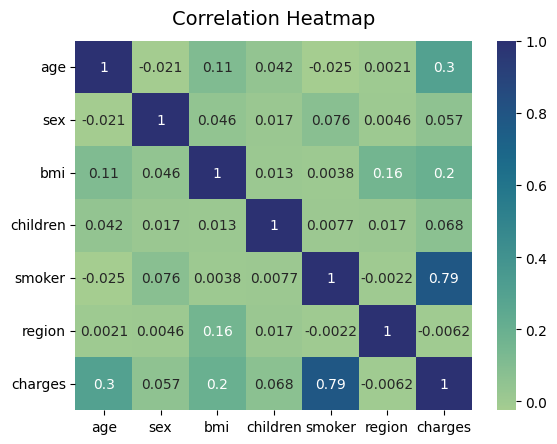

In [12]:
plt.figure()
sns.heatmap(data.corr(), annot=True, cmap='crest').set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.show()

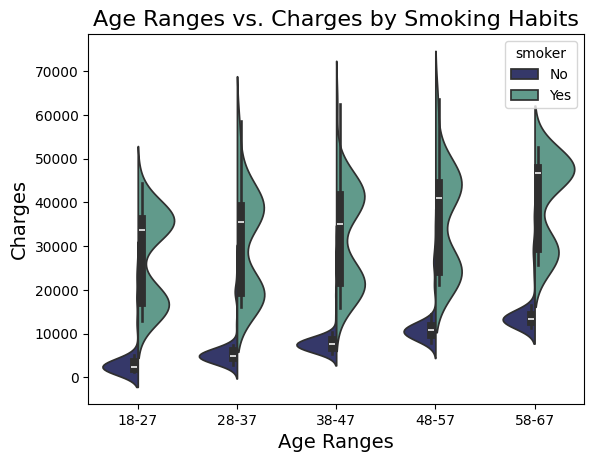

In [13]:
df_ages = data.copy()
age_ranges = range(18, 74, 10)
age_labels = [f'{i}-{i+9}' for i in age_ranges[:-1]]
df_ages['age_ranges'] = pd.cut(df_ages['age'], bins=age_ranges, labels=age_labels, right=False)
df_ages['smoker'] = df_ages['smoker'].map({1: 'Yes', 0: 'No'})

my_pal = {smoker: "#57a490" if smoker ==
            "Yes" else "#2c3172" for smoker in df_ages["smoker"].unique()}

plt.figure()
ax = sns.violinplot(df_ages, x='age_ranges', y='charges', hue='smoker', split=True, palette= my_pal, hue_order=['No', 'Yes']).set_title('Age Ranges vs. Charges by Smoking Habits', fontsize=16)
plt.xlabel('Age Ranges', fontsize=14)
plt.ylabel('Charges', fontsize=14)
plt.show()

We also decided to use the method "describe" to get more insight with the numerical data, now we can see that the mean amount of charges is of $13,270 USD, this is going to be useful later to check the percentage of the relative error of the model.

In [14]:
data.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


## Models

### Base Model: Linear Regression

In this case for the Linear Regression we didn't apply a GridSearch, we are going to use it as the base model for the rest of the models, so the pipeline is just going to include the Standard Scaler and the Linear Regression. We ended up with a R² Score of 0.685 and a RMSE of 6994.30, this is going to be the base for the next models.

In [15]:
feature_pipe_lr = Pipeline([
    ('scaler', StandardScaler())
])

model_lr = TransformedTargetRegressor(
    regressor=Pipeline([
        ('features', feature_pipe_lr),
        ('lr', LinearRegression())
    ]),
    transformer=pt
)

# Training Linear
model_lr.fit(X_train, y_train) 

predictions = model_lr.predict(X_test)

r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'R² Linear Regression: {r2:.3f}')
print(f'RMSE Linear Regression: {rmse:.2f} USD\n')

R² Linear Regression: 0.685
RMSE Linear Regression: 6994.30 USD



### Lasso Regression
The GridSearchCV for the hyperparameters gave us a Polynomial Feature of degree six and an alpha for the model of 0.005, this gave us an R² Score of 0.860 and a RMSE of 4656.95, a great improvement compared with the base model.

In [16]:
feature_pipe_lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=6)),
    ('scaler', StandardScaler())
])

model_lasso = TransformedTargetRegressor(
    regressor=Pipeline([
        ('features', feature_pipe_lasso),
        ('lasso', Lasso(alpha=0.005))
    ]),
    transformer=pt
)

# Training Lasso
model_lasso.fit(X_train, y_train) 

predictions = model_lasso.predict(X_test)

r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'R² Lasso Regression: {r2:.3f}')
print(f'RMSE Lasso Regression: {rmse:.2f} USD\n')

R² Lasso Regression: 0.860
RMSE Lasso Regression: 4659.95 USD



### Ridge Regression
The GridSearchCV for the hyperparameters gave us a Polynomial Feature of degree two and an alpha for the model of 3, this gave us an R² Score of 0.863 and a RMSE of 4605.22, an improvement from the Lasso Model.

In [17]:
feature_pipe_ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

model_ridge = TransformedTargetRegressor(
    regressor=Pipeline([
        ('features', feature_pipe_ridge),
        ('ridge', Ridge(alpha=3))
    ]),
    transformer=pt
)

# Training Ridge
model_ridge.fit(X_train, y_train) 

predictions = model_ridge.predict(X_test)

r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'R² Ridge Regression: {r2:.3f}')
print(f'RMSE Ridge Regression: {rmse:.2f} USD\n')

R² Ridge Regression: 0.863
RMSE Ridge Regression: 4605.22 USD



### Elastic Net Model

The GridSearchCV for the hyperparameters gave us a Polynomial Feature of degree 6, an alpha of 0.005 and a l1 ratio of 0.1; this gave us an R² Score of 0.850 and a RMSE of 4818.27.

In [ ]:
feature_pipe_elastic = Pipeline([
    ('poly', PolynomialFeatures(degree=6)),
    ('scaler', StandardScaler())
])

model_elastic = TransformedTargetRegressor(
    regressor=Pipeline([
        ('features', feature_pipe_elastic),
        ('elastic', ElasticNet(alpha=0.005, l1_ratio=0.1, max_iter=100000))
    ]),
    transformer=pt
)

# Training Elastic
model_elastic.fit(X_train, y_train) 

predictions = model_elastic.predict(X_test)

r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'R² Elastic Net Regression: {r2:.3f}')
print(f'RMSE Elastic Net Regression: {rmse:.2f} USD\n')

### Recommended Model
In this case the model with the best results were the Ridge Model with:
- R² Ridge Regression: 0.863
- RMSE Ridge Regression: 4605.22 USD

This means that the model explains the 86.3% of the variability of the charges with mean error of around ±$4,605 with respect of the real value, compared with the mean of $13,270 ($13,270/$4,605) there is a deviation of 34.7%.

The Ridge Model gives us a improvement of 26% in the R² Score and compared to the 34.7% of deviation of the Ridge Model, the base model gives us a 52.7%, this means that there is a reduction of 18% of the relative deviation and of 34.2% in the RMSE, we can visualize below. Finally we can see the results of the Ridge Model in the second image below.

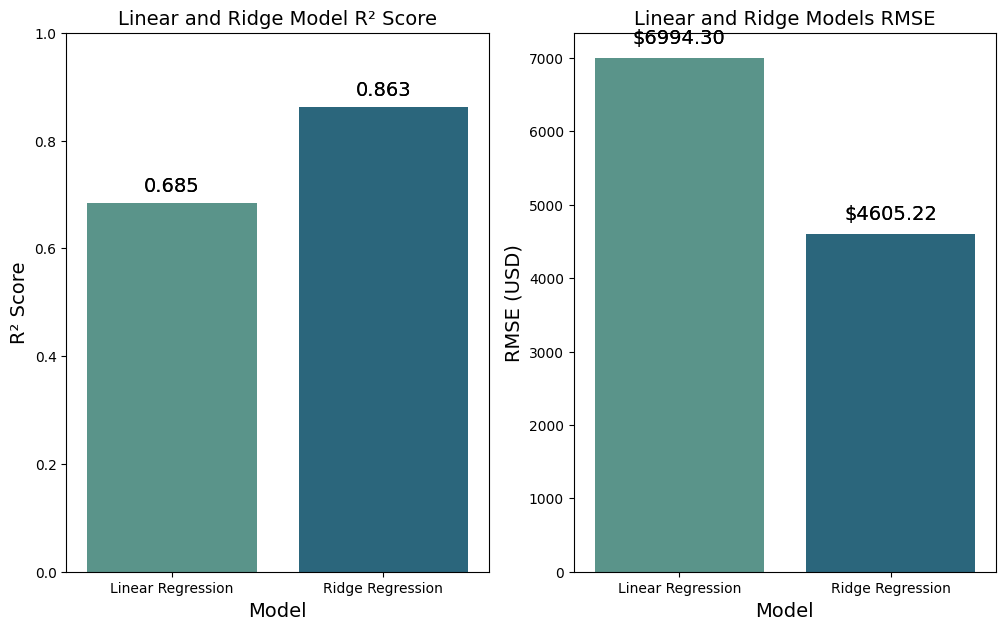

In [ ]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression'],
    'R2': [0.685, 0.863],
    'RMSE': [6994.30, 4605.22]
})
      
plt.figure(figsize=(12, 7))

ax=plt.subplot(121)
ax1= sns.barplot(data=results, x='Model', y='R2', palette='crest', hue='Model', legend=False)
ax.set_title('Linear and Ridge Model R² Score', fontsize=14)
ax.set_ylabel('R² Score', fontsize=14)
ax.set_xlabel('Model', fontsize=14)
ax.set_ylim(0, 1)
for p in ax1.patches:
    for i, v in enumerate(results['R2']):
        ax1.text(i, v+0.02, f'{v:.3f}', ha='center', fontsize=14)

ax=plt.subplot(122)
ax2= sns.barplot(data=results, x='Model', y='RMSE', palette='crest', hue='Model', legend=False)
ax.set_title('Linear and Ridge Models RMSE', fontsize=14)
ax.set_ylabel('RMSE (USD)', fontsize=14)
ax.set_xlabel('Model', fontsize=14)
for p in ax2.patches:
    for i, v in enumerate(results['RMSE']):
        ax2.text(i, v+200, f'${v:.2f}', ha='center', fontsize=14)

plt.show()

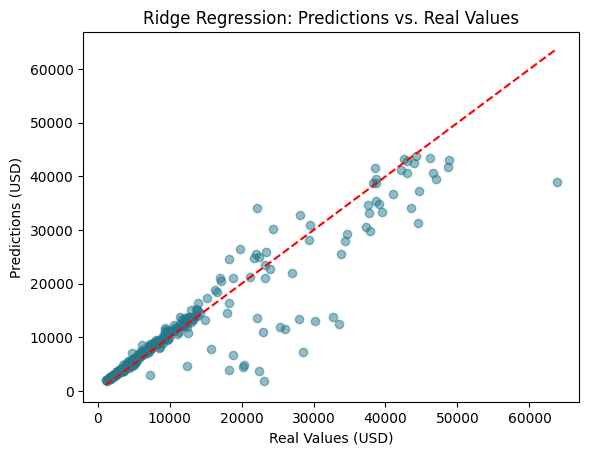

In [ ]:
plt.scatter(y_test, predictions, alpha=0.5, c='#25788c', cmap='crest',)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real Values (USD)')
plt.ylabel('Predictions (USD)')
plt.title('Ridge Regression: Predictions vs. Real Values')
plt.show()

### Next Steps and Improvements
We could investigate better ways to normalize the data for the target value and try other regression models such as RD Regression, Bayesian Ridge or XGBoost. 